In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import json

In [2]:
data_file = '../../Datasets/NYPD_Motor_Vehicle_Collisions.csv'
df = pd.read_csv(data_file)

/Users/davidhaase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning
### Summarize the shape
`df.shape`
* (1507923, 29)
* 29 features (columns)
* 1,507,923 collisions (rows)



`df.info()`
* RangeIndex: 1507923 entries, 0 to 1507922
* Data columns (total 29 columns)
* dtypes: float64(4), int64(7), object(18)
* memory usage: 333.6+ MB

`DATE                             1507923 non-null object
TIME                             1507923 non-null object
BOROUGH                          1055432 non-null object
ZIP CODE                         1055253 non-null object
LATITUDE                         1319709 non-null float64
LONGITUDE                        1319709 non-null float64
LOCATION                         1319709 non-null object
ON STREET NAME                   1217162 non-null object
CROSS STREET NAME                1020629 non-null object
OFF STREET NAME                  198606 non-null object
NUMBER OF PERSONS INJURED        1507906 non-null float64
NUMBER OF PERSONS KILLED         1507892 non-null float64
NUMBER OF PEDESTRIANS INJURED    1507923 non-null int64
NUMBER OF PEDESTRIANS KILLED     1507923 non-null int64
NUMBER OF CYCLIST INJURED        1507923 non-null int64
NUMBER OF CYCLIST KILLED         1507923 non-null int64
NUMBER OF MOTORIST INJURED       1507923 non-null int64
NUMBER OF MOTORIST KILLED        1507923 non-null int64
CONTRIBUTING FACTOR VEHICLE 1    1504001 non-null object
CONTRIBUTING FACTOR VEHICLE 2    1306911 non-null object
CONTRIBUTING FACTOR VEHICLE 3    97164 non-null object
CONTRIBUTING FACTOR VEHICLE 4    20199 non-null object
CONTRIBUTING FACTOR VEHICLE 5    5142 non-null object
UNIQUE KEY                       1507923 non-null int64
VEHICLE TYPE CODE 1              1503118 non-null object
VEHICLE TYPE CODE 2              1263185 non-null object
VEHICLE TYPE CODE 3              126564 non-null object
VEHICLE TYPE CODE 4              48051 non-null object
VEHICLE TYPE CODE 5              10256 non-null object`



### Drop unnecessary columns

In [3]:
drop_columns = ['LOCATION', 'BOROUGH', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'CONTRIBUTING FACTOR VEHICLE 1', 'ZIP CODE', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5']
df = df.drop(drop_columns, axis=1)

In [4]:
df.isna().sum()

DATE                              0
TIME                              0
NUMBER OF PERSONS INJURED        17
NUMBER OF PERSONS KILLED         31
NUMBER OF PEDESTRIANS INJURED     0
NUMBER OF PEDESTRIANS KILLED      0
NUMBER OF CYCLIST INJURED         0
NUMBER OF CYCLIST KILLED          0
NUMBER OF MOTORIST INJURED        0
NUMBER OF MOTORIST KILLED         0
dtype: int64

### NaNs
`DATE                              0
TIME                              0
NUMBER OF PERSONS INJURED        17
NUMBER OF PERSONS KILLED         31
NUMBER OF PEDESTRIANS INJURED     0
NUMBER OF PEDESTRIANS KILLED      0
NUMBER OF CYCLIST INJURED         0
NUMBER OF CYCLIST KILLED          0
NUMBER OF MOTORIST INJURED        0
NUMBER OF MOTORIST KILLED         0
dtype: int64
`
#### Drop NaNs
Relative to the total 1.5M collisions, the number of collisions for the two features with NaNs is low.  Let's just get rid of them.

In [5]:
df = df.dropna()
df.isna().sum()

DATE                             0
TIME                             0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
dtype: int64

### Convert Data Types
#### Dates
(ATTENTION: the code below will take a few minutes)

In [6]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['TIME'] = pd.to_datetime(df['TIME'])

####  Floats

In [7]:
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype(int)
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype(int)

In [8]:
##############################
# BREAKPOINT — Save to disk (json)
# data_file = 'data/cleaned_traffic_data.json'
# df.to_json(data_file)


# Load from disk (json)
# If you just want to start with the clean data, start here.
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import json

# data_file = 'data/cleaned_traffic_data.json'
# with open(data_file) as json_file:  
#     data = json.load(json_file)  
#     df = pd.DataFrame(data)

## Data Engineering
### Visualize daily collision totals

In [9]:
collisions_by_date = df['DATE'].value_counts().reset_index()
collisions_by_date.describe()

,DATE
count,2528.000000
mean,596.474288
std,100.701513
min,188.000000
25%,528.000000
50%,598.000000
75%,662.000000
max,1161.000000


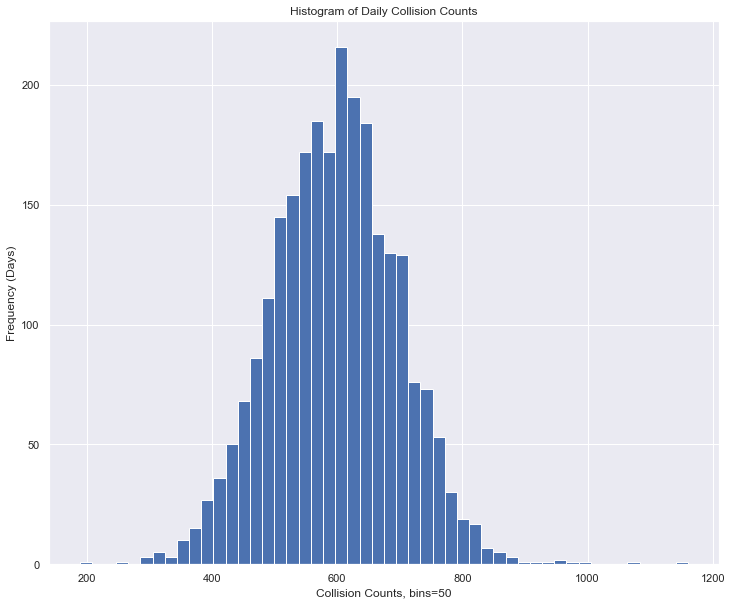

In [83]:
# hist = collisions_by_date.hist(bins=100)
# sns.distplot(collisions_by_date,kde = False)
# sns.distplot(collisions_by_date['DATE'], kde=True, bins=50)
# n, bins, patches = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)
plt.hist(collisions_by_date['DATE'], bins=50)
plt.xlabel('Collision Counts, bins=50')
plt.ylabel('Frequency (Days)')
plt.title('Histogram of Daily Collision Counts')
plt.savefig('data/histogram-collisions-per-day.png')

### Convert to days of the week

In [18]:
weekdays = df['DATE'].value_counts().reset_index()
weekdays['day_of_week'] = weekdays['index'].dt.day_name()
weekdays.drop('index', axis=1, inplace=True)

In [19]:
weekdays = weekdays.rename(index=str, columns={"DATE": "collisions"})

## Hypothesis Testing
### H-T2 Days of the Week (ANOVA)—Does the day of the weekday have an effect on the number of collisions?
* __Null Hypothesis (H<sub>0</sub>)__:  The day of a weekday does not have an effect on the number of collisions
* __Alternative Hypothesis (H<sub>1</sub>)__: The day of a weekday _does_ have an effect on the number of collisions

#### Box plots for each day of the week

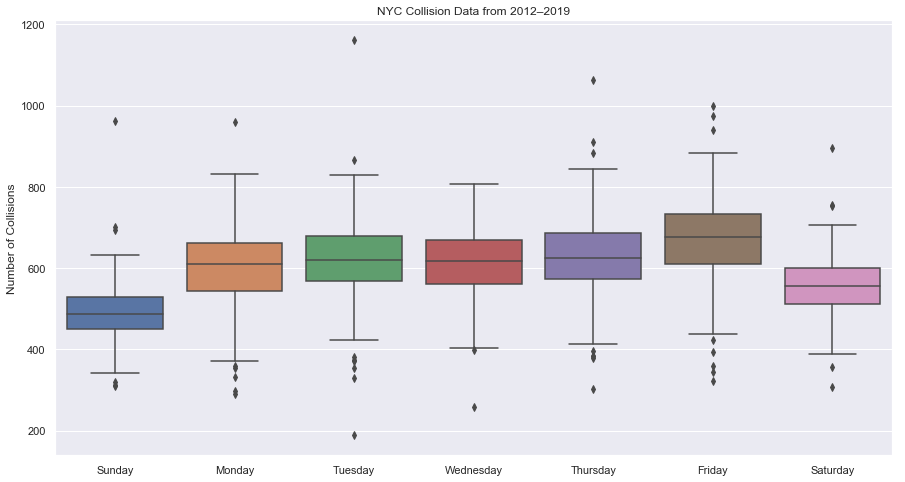

In [74]:
fig = plt.figure(figsize=(15,8))
sns.boxplot(x="day_of_week", y="collisions", data=weekdays, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.xlabel('')
plt.ylabel('Number of Collisions')
plt.title('NYC Collision Data from 2012–2019')
plt.savefig('images/boxplot-collisions-by-day.png')

#### ANOVA results from OLS

In [21]:
formula = 'collisions ~ C(day_of_week)'
lm = ols(formula, weekdays).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(day_of_week),7.366846e+06,6.0,169.522588,1.872246e-181
Residual,1.825894e+07,2521.0,NaN,NaN


### H-T2.1 Fridays vs. Sundays

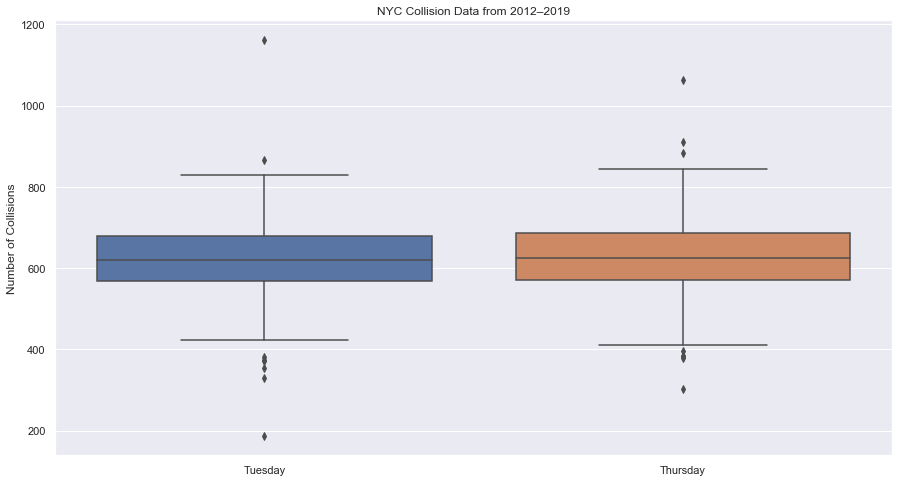

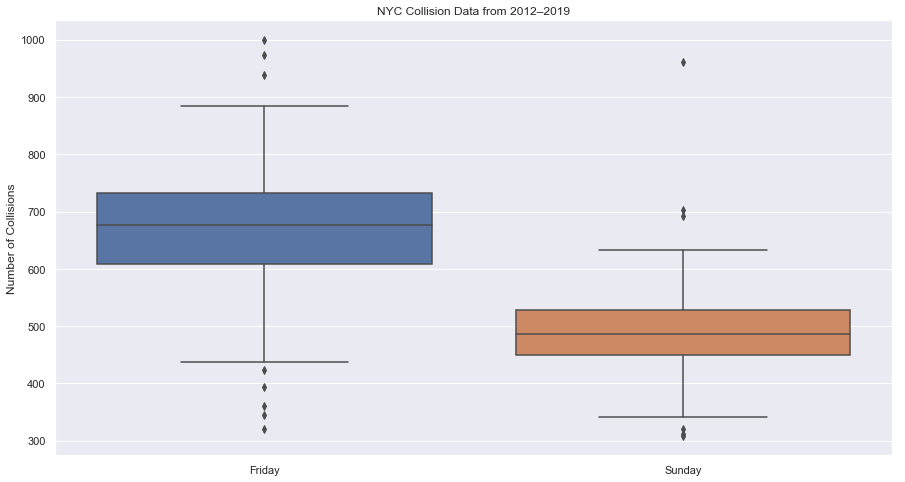

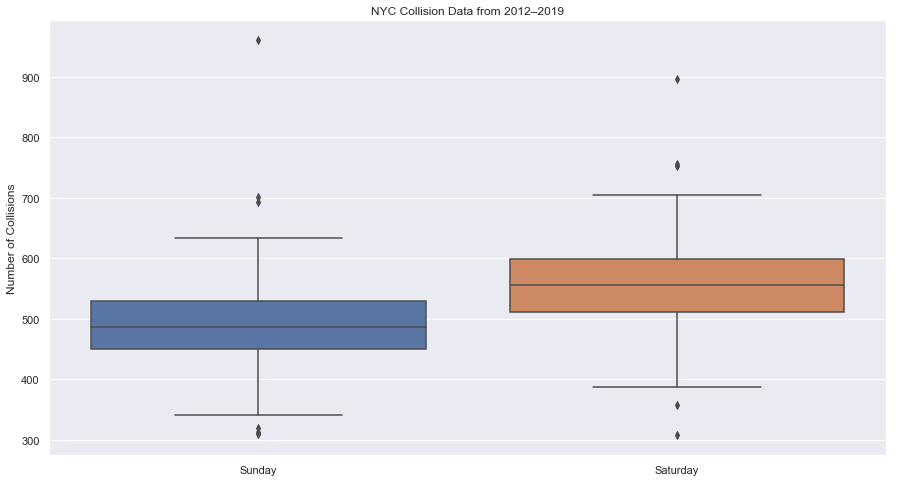

In [139]:
def boxplot_daypairs(pairs, df):
    for pair in pairs:
        filename = 'images/boxplots/boxplot-collisions-by-' + pair[0] + '-' + pair[1] + '.png'
        pair_df = df[(df['day_of_week'] == pair[0]) | (df['day_of_week'] == pair[1])]
        fig = plt.figure(figsize=(15,8))
        sns.boxplot(x="day_of_week", y="collisions", data=pair_df)
        plt.xlabel('')
        plt.ylabel('Number of Collisions')
        plt.title('NYC Collision Data from 2012–2019')
        plt.savefig(filename)
    
    
day_pairs = [['Thursday', 'Tuesday'], ['Friday', 'Sunday'], ['Saturday', 'Sunday']]
boxplot_daypairs(day_pairs, weekdays)

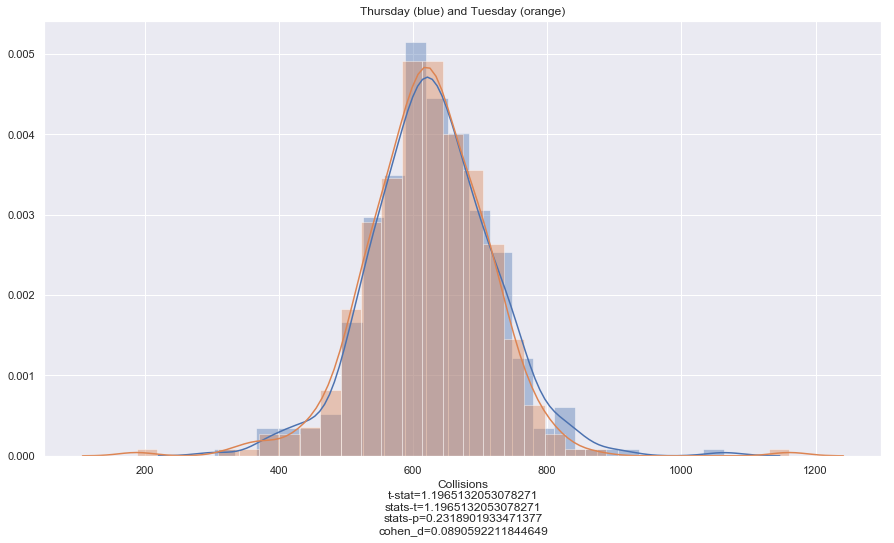

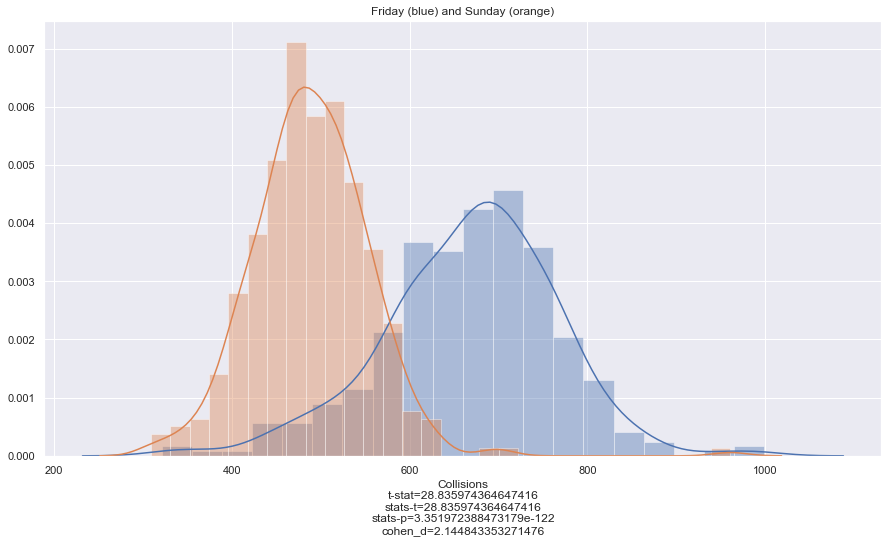

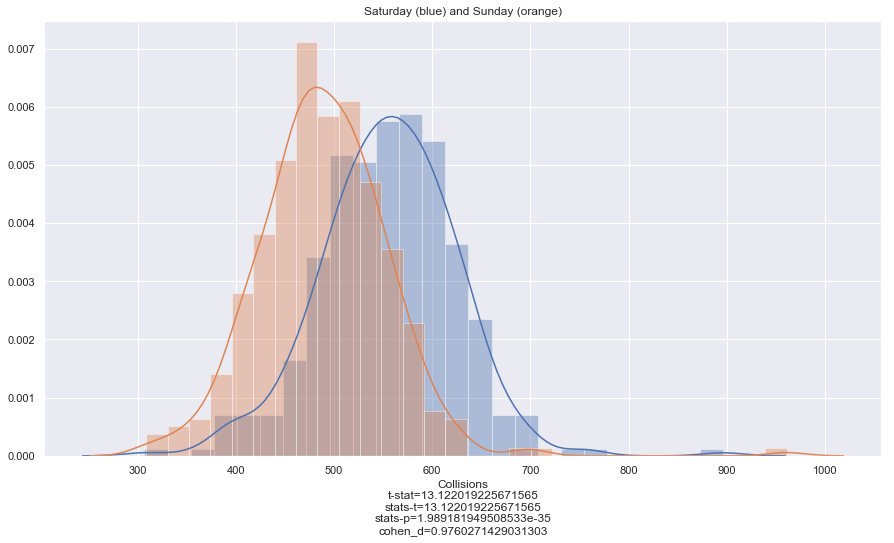

In [138]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

def pooled_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = sample_variance(sample1), sample_variance(sample2)
    return ((n_1-1) * var_1 + (n_2-1)* var_2)/((n_1 + n_2)-2)

def twosample_tstatistic(expr, ctrl):
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    pool_var = pooled_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/n_e)+(1/n_c)))
    return num / denom

def distplot_daypairs(pairs, df):
    for pair in pairs:
        filename = 'images/distplots/displot-collisions-by-' + pair[0] + '-' + pair[1] + '.png'
        day1 = df.loc[df['day_of_week'] == pair[0], 'collisions']
        day2 = df.loc[df['day_of_week'] == pair[1], 'collisions']
        t_stat = twosample_tstatistic(day1, day2)
        (stats_t, stats_p) = stats.ttest_ind(day1, day2)
        cd = Cohen_d(day1, day2)
        fig = plt.figure(figsize=(15,8))
        sns.set(rc={'figure.figsize':(12,10)})
        sns.distplot(day1)
        sns.distplot(day2)
        plt.xlabel('Collisions\nt-stat={}\nstats-t={}\nstats-p={}\ncohen_d={}'.format(t_stat, stats_t, stats_p, cd))
        plt.ylabel('')
        plt.title(pair[0] + ' (blue) and ' + pair[1] + ' (orange)')
        plt.savefig(filename)
    
    
day_pairs = [['Thursday', 'Tuesday'], ['Friday', 'Sunday'], ['Saturday', 'Sunday']]
distplot_daypairs(day_pairs, weekdays)

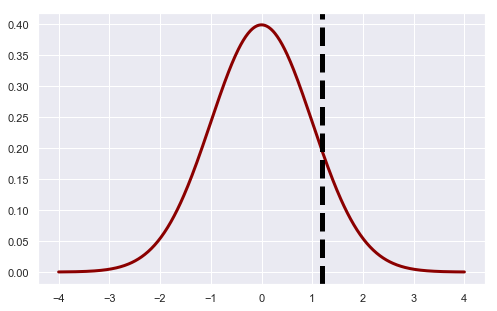

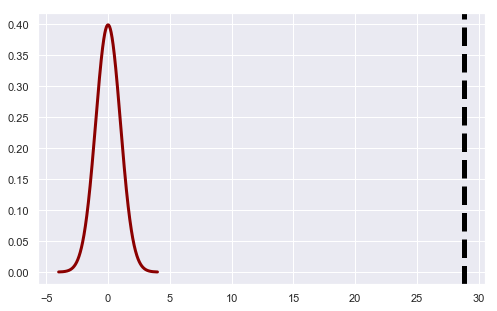

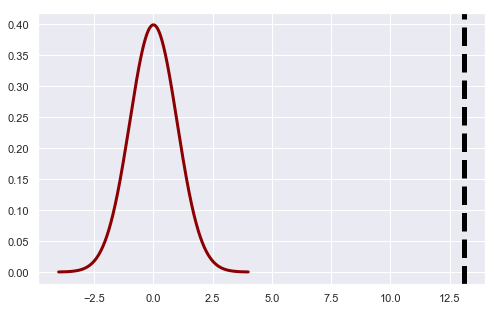

In [140]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
#     ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

def visualize_t_daypairs(pairs, df):
    for pair in pairs:
        filename = 'images/distplots/displot-collisions-by-' + pair[0] + '-' + pair[1] + '.png'
        day1 = df.loc[df['day_of_week'] == pair[0], 'collisions']
        day2 = df.loc[df['day_of_week'] == pair[1], 'collisions']
        t_stat = twosample_tstatistic(day1, day2)
        visualize_t(t_stat, len(day1), len(day2))
    

visualize_t_daypairs(day_pairs, weekdays)

1.325615517895698

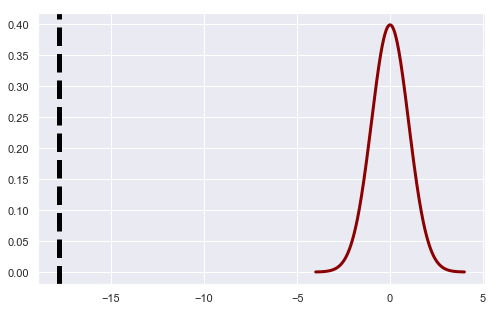

In [46]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)